In [1]:
import pandas as pd
import numpy as np
import os
import json
import re

In [20]:
NUM_VERSIONS = 3
NUM_QUESTIONS = 5
LLM_VERSION = "mistral"

In [ ]:
# open dir ../configs
# Get the current working directory of the notebook
notebook_path = os.getcwd()


# Collect all answer DataFrames for each version
all_answers_versions = [[] for _ in range(NUM_VERSIONS * NUM_QUESTIONS)]
json_files_versions = [[] for _ in range(NUM_VERSIONS * NUM_QUESTIONS)]


for question_index in range(NUM_QUESTIONS):

    config_path = os.path.join(notebook_path, f"../config/question_{question_index}")

    print(config_path)

    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]

    print(subdirs)

    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        config_file = os.path.join(subdir_path, "config_0.json")
        try:
            with open(config_file, "r") as file:
                config_data = json.load(file)
            config_df = pd.json_normalize(config_data)
            party_1 = config_df["persons"][0][0]["party"]
            party_2 = config_df["persons"][0][1]["party"]
            namme_1 = config_df["persons"][0][0]["name"]
            namme_2 = config_df["persons"][0][1]["name"]

        except Exception as e:
            print(f"Error reading {config_file}: {e}")
            continue

        for v in range(NUM_VERSIONS):
            json_file = os.path.join(subdir_path, f"out_{LLM_VERSION}_v{v}.json")
            if os.path.isfile(json_file):
                json_files_versions[v].append(json_file)
            else:
                continue
            try:
                with open(json_file, "r") as file:
                    data = json.load(file)
            except Exception as e:
                print(f"Error reading {json_file}: {e}")
                continue

            columns = {}
            columns["question_index"] = question_index
            columns["party_1"] = party_1
            columns["party_2"] = party_2

            for q in data["survey_question"]:
                name = q["chat_entry"]["entity"]["name"]
                name = "agent_1" if name == namme_1 else "agent_2"
                iteration = q["iteration"]
                col_name = f"{name}_T{iteration}"
                columns[col_name] = q["chat_entry"]["answer"]

            answers_df = pd.DataFrame([columns])

            all_answers_versions[v + question_index * NUM_VERSIONS].append(answers_df)

/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_0
['CDU_CSU-AfD', 'Bündnis_90_Die_Grünen-AfD', 'Die_Linke-FDP', 'SPD-SPD', 'SPD-keine_Partei', 'Die_Linke-Die_Linke', 'FDP-FDP', 'AfD-AfD', 'CDU_CSU-keine_Partei', 'Bündnis_90_Die_Grünen-Bündnis_90_Die_Grünen', 'SPD-AfD', 'FDP-keine_Partei', 'Die_Linke-Bündnis_90_Die_Grünen', 'CDU_CSU-CDU_CSU', 'FDP-AfD', 'keine_Partei-keine_Partei', 'SPD-Bündnis_90_Die_Grünen', 'Bündnis_90_Die_Grünen-FDP', 'Bündnis_90_Die_Grünen-keine_Partei', 'Die_Linke-AfD', 'Die_Linke-CDU_CSU', 'Bündnis_90_Die_Grünen-CDU_CSU', 'Die_Linke-keine_Partei', 'AfD-keine_Partei', 'Die_Linke-SPD', 'SPD-CDU_CSU', 'SPD-FDP', 'FDP-CDU_CSU']
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_1
['CDU_CSU-AfD', 'Bündnis_90_Die_Grünen-AfD', 'Die_Linke-FDP', 'SPD-SPD', 'SPD-keine_Partei', 'Die_Linke-Die_Linke', 'FDP-FDP', 'AfD-AfD', 'CDU_CSU-keine_Partei', 'Bündnis_90_Die_Grünen-Bündnis_90_Die_Grünen', 'SPD-AfD', 'FDP-keine_Partei', 'Die_Linke-Bünd

In [4]:
big_dfs = []
for v in range(NUM_VERSIONS * NUM_QUESTIONS):
    if all_answers_versions[v]:
        # print(f"all_answers_versions[{v}]: {all_answers_versions[v]}")
        big_df = pd.concat(all_answers_versions[v], ignore_index=True)
        big_dfs.append(big_df)

        display(big_df)

        init_opinions: pd.DataFrame = big_df[["agent_1_T0", "agent_2_T0"]].copy()
        init_opinions = init_opinions.apply(pd.to_numeric, errors="coerce")
        init_opinions = init_opinions.dropna()
        init_opinions = init_opinions.astype(float)
        init_opinions = (
            init_opinions["agent_1_T0"].tolist() + init_opinions["agent_2_T0"].tolist()
        )
        init_mean = np.mean(init_opinions)
        init_std = np.std(init_opinions)
        print(f"Initial mean for version {v}: {init_mean}")
        print(f"Initial std for version {v}: {init_std}")

        last_opinions: pd.DataFrame = big_df[["agent_1_T20", "agent_2_T20"]].copy()
        last_opinions = last_opinions.apply(pd.to_numeric, errors="coerce")
        last_opinions = last_opinions.dropna()
        last_opinions = last_opinions.astype(float)
        last_mean = np.mean(last_opinions)
        last_std = np.std(last_opinions)
        print(f"Last mean for version {v}: {last_mean}")
        print(f"Last std for version {v}: {last_std}")

    else:
        print(f"No dataframes to concatenate for version {v}.")

# print(v)

,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,4,3,5,3,5,3,6,3,6,3,6,3
1,0,Bündnis 90/Die Grünen,AfD,4,2,4,2,4,2,4,2,4,2,4,2
2,0,Die Linke,FDP,6,5,6,4,6,5,5,5,6,5,6,5
3,0,SPD,SPD,4,3,5,3,5,3,6,3,6,3,6,3
4,0,SPD,keine Partei,5,7,6,7,6,7,6,7,6,7,6,7
5,0,Die Linke,Die Linke,6,7,7,7,7,7,7,7,6,7,6,7
6,0,FDP,FDP,4,5,5,5,5,5,5,5,5,5,5,5
7,0,AfD,AfD,2,2,2,3,3,3,2,3,3,3,3,4
8,0,CDU/CSU,keine Partei,4,5,3,5,4,5,4,5,4,5,4,5
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,4,4,4,4,4,4,4,5,4,4,4


Initial mean for version 0: 4.696428571428571
Initial std for version 0: 1.2944889071028167
Last mean for version 0: 5.142857142857143
Last std for version 0: agent_1_T20    0.981331
agent_2_T20    1.379052
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,4,4,5,3,5,2,5,3,5,3,5,3
1,0,Bündnis 90/Die Grünen,AfD,4,3,5,5,4,5,4,5,4,6,4,6
2,0,Die Linke,FDP,5,4,6,4,6,4,6,4,6,4,6,4
3,0,SPD,SPD,4,4,5,3,5,3,5,3,5,3,5,3
4,0,SPD,keine Partei,5,7,6,7,6,7,6,7,6,7,6,7
5,0,Die Linke,Die Linke,6,7,7,7,7,7,7,7,6,7,7,7
6,0,FDP,FDP,4,5,5,5,5,5,5,6,5,6,5,5
7,0,AfD,AfD,2,2,2,3,2,5,2,4,2,5,2,5
8,0,CDU/CSU,keine Partei,4,5,4,6,4,6,5,6,5,6,5,6
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,5,4,4,4,4,5,5,5,4,5,4


Initial mean for version 1: 4.75
Initial std for version 1: 1.242836617236094
Last mean for version 1: 5.25
Last std for version 1: agent_1_T20    1.115750
agent_2_T20    1.360897
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,4,3,5,3,5,2,5,3,5,3,5,3
1,0,Bündnis 90/Die Grünen,AfD,4,2,5,3,5,3,5,3,5,3,5,3
2,0,Die Linke,FDP,6,4,6,4,6,4,6,4,6,4,6,4
3,0,SPD,SPD,4,3,5,3,5,2,6,3,5,3,5,3
4,0,SPD,keine Partei,5,6,6,7,6,7,6,7,6,7,6,7
5,0,Die Linke,Die Linke,6,7,7,7,6,7,7,6,6,7,6,7
6,0,FDP,FDP,5,6,4,4,4,4,4,4,4,4,4,5
7,0,AfD,AfD,2,2,3,3,2,4,2,6,3,6,2,5
8,0,CDU/CSU,keine Partei,4,5,5,5,5,5,5,5,5,5,5,5
9,0,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,5,5,4,5,4,5,4,6,4,6,4


Initial mean for version 2: 4.678571428571429
Initial std for version 2: 1.2970728426667768
Last mean for version 2: 4.982142857142857
Last std for version 2: agent_1_T20    1.115750
agent_2_T20    1.295105
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,5,5,5,4,5,4,6,4,6,5,6,5
1,1,Bündnis 90/Die Grünen,AfD,4,5,5,5,5,5,5,6,4,6,5,5
2,1,Die Linke,FDP,3,4,3,4,3,4,3,4,3,4,3,4
3,1,SPD,SPD,4,5,5,4,5,4,5,4,5,4,5,4
4,1,SPD,keine Partei,4,2,4,3,4,2,4,3,4,3,4,3
5,1,Die Linke,Die Linke,3,2,2,2,2,2,2,2,2,2,2,2
6,1,FDP,FDP,4,3,4,4,4,4,4,4,4,4,4,4
7,1,AfD,AfD,6,5,6,5,6,5,6,5,7,5,6,6
8,1,CDU/CSU,keine Partei,5,3,6,3,6,4,5,4,6,4,5,4
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,4,5,4,5,5,5,4,5,5,5,4


Initial mean for version 3: 3.8703703703703702
Initial std for version 3: 0.9437179486104373
Last mean for version 3: 4.351851851851852
Last std for version 3: agent_1_T20    1.018350
agent_2_T20    0.908729
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,5,5,5,5,5,5,5,5,5,5,5,5
1,1,Bündnis 90/Die Grünen,AfD,4,5,5,6,5,6,5,6,5,6,5,6
2,1,Die Linke,FDP,3,4,3,4,3,4,3,4,3,4,3,4
3,1,SPD,SPD,4,5,5,5,5,5,5,5,4,5,5,4
4,1,SPD,keine Partei,4,2,4,2,3,2,3,2,3,2,3,2
5,1,Die Linke,Die Linke,2,2,2,2,2,2,2,2,2,2,2,2
6,1,FDP,FDP,4,4,4,4,4,4,4,4,4,4,4,4
7,1,AfD,AfD,5,6,6,6,6,6,7,7,6,6,6,6
8,1,CDU/CSU,keine Partei,5,3,5,4,5,4,5,4,5,4,5,4
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,4,5,4,5,4,5,5,5,5,5,5


Initial mean for version 4: 3.875
Initial std for version 4: 0.9647816185171499
Last mean for version 4: 4.196428571428571
Last std for version 4: agent_1_T20    1.179653
agent_2_T20    1.108870
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,1,CDU/CSU,AfD,5,5,5,5,5,4,5,4,5,5,5,4
1,1,Bündnis 90/Die Grünen,AfD,4,5,5,3,5,4,5,4,5,4,5,4
2,1,Die Linke,FDP,3,4,3,4,4,4,3,4,3,4,3,4
3,1,SPD,SPD,4,5,5,4,5,4,5,5,5,4,5,5
4,1,SPD,keine Partei,4,2,5,3,5,3,4,3,4,3,4,3
5,1,Die Linke,Die Linke,2,2,2,2,2,2,2,2,2,2,2,2
6,1,FDP,FDP,4,4,4,4,4,4,4,5,4,4,4,4
7,1,AfD,AfD,6,5,6,6,6,6,6,6,6,6,6,6
8,1,CDU/CSU,keine Partei,5,3,5,4,5,4,5,4,5,4,5,4
9,1,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,4,5,5,5,4,5,5,5,4,5,5


Initial mean for version 5: 3.9107142857142856
Initial std for version 5: 1.0398623829671905
Last mean for version 5: 4.25
Last std for version 5: agent_1_T20    1.135580
agent_2_T20    0.927884
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,3,3,6,3,5,3,5,3,5,3,5,3
1,2,Bündnis 90/Die Grünen,AfD,5,4,5,3,6,3,6,3,6,3,6,3
2,2,Die Linke,FDP,6,5,5,4,6,5,6,5,6,5,6,5
3,2,SPD,SPD,4,4,5,3,5,3,5,3,5,3,5,3
4,2,SPD,keine Partei,5,7,6,7,6,7,6,7,6,7,6,7
5,2,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,2,FDP,FDP,4,6,4,6,4,6,4,6,3,6,4,6
7,2,AfD,AfD,3,2,3,5,3,5,2,5,3,6,3,6
8,2,CDU/CSU,keine Partei,5,6,3,6,3,6,3,6,3,6,4,6
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,5,6,5,6,5,6,5,6,5,6,5


Initial mean for version 6: 4.982142857142857
Initial std for version 6: 1.2025430112380808
Last mean for version 6: 5.464285714285714
Last std for version 6: agent_1_T20    1.080320
agent_2_T20    1.310768
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,3,3,3,3,3,3,3,2,3,2,3,3
1,2,Bündnis 90/Die Grünen,AfD,5,3,6,3,6,3,6,3,6,2,6,3
2,2,Die Linke,FDP,6,5,6,6,6,6,6,6,7,6,7,6
3,2,SPD,SPD,5,3,5,3,5,3,5,3,6,3,6,3
4,2,SPD,keine Partei,5,7,6,7,6,7,6,7,6,7,6,7
5,2,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,2,FDP,FDP,4,6,6,6,6,6,6,6,6,6,6,6
7,2,AfD,AfD,2,3,3,5,2,5,2,6,2,6,2,6
8,2,CDU/CSU,keine Partei,4,6,3,6,3,6,3,6,3,6,3,6
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,5,6,5,6,6,6,6,6,6,6,6


Initial mean for version 7: 4.821428571428571
Initial std for version 7: 1.2263060509563852
Last mean for version 7: 5.357142857142857
Last std for version 7: agent_1_T20    1.475998
agent_2_T20    1.472538
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,2,CDU/CSU,AfD,4,3,5,3,5,3,5,3,5,3,5,3
1,2,Bündnis 90/Die Grünen,AfD,5,3,5,3,6,3,6,3,6,3,6,3
2,2,Die Linke,FDP,6,5,6,6,6,6,6,6,6,6,6,6
3,2,SPD,SPD,4,3,4,5,4,5,4,6,4,5,4,5
4,2,SPD,keine Partei,6,7,6,7,6,7,7,7,7,7,7,7
5,2,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,2,FDP,FDP,5,6,5,6,6,6,6,6,6,6,6,6
7,2,AfD,AfD,2,3,3,5,3,5,2,6,2,6,3,6
8,2,CDU/CSU,keine Partei,4,6,6,6,6,6,6,6,6,6,6,6
9,2,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,5,5,4,5,3,5,3,5,3,5,3


Initial mean for version 8: 4.928571428571429
Initial std for version 8: 1.2371791482634837
Last mean for version 8: 5.5
Last std for version 8: agent_1_T20    1.205853
agent_2_T20    1.397885
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,3,5,2,5,2,4,2,3,2,3,2,4
1,3,Bündnis 90/Die Grünen,AfD,2,5,3,5,2,5,2,3,2,3,2,3
2,3,Die Linke,FDP,2,2,1,1,1,1,1,1,1,1,1,1
3,3,SPD,SPD,2,5,2,3,2,3,2,2,2,3,2,3
4,3,SPD,keine Partei,2,1,2,1,1,1,1,1,1,1,1,1
5,3,Die Linke,Die Linke,2,1,1,1,1,1,1,1,1,1,1,1
6,3,FDP,FDP,3,2,3,2,2,1,3,2,2,2,2,2
7,3,AfD,AfD,6,5,5,3,5,3,5,3,4,3,5,3
8,3,CDU/CSU,keine Partei,3,2,1,1,2,1,2,2,2,1,2,2
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,3,2,2,2,2,2,2,1,2,2,2,2


Initial mean for version 9: 2.5714285714285716
Initial std for version 9: 1.279748061940637
Last mean for version 9: 1.7321428571428572
Last std for version 9: agent_1_T20    0.820652
agent_2_T20    0.976118
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,3,5,2,6,2,5,2,6,2,5,2,5
1,3,Bündnis 90/Die Grünen,AfD,2,6,2,6,2,5,2,5,2,5,2,5
2,3,Die Linke,FDP,2,3,1,2,1,1,1,1,1,1,1,1
3,3,SPD,SPD,3,4,2,6,2,5,2,4,2,4,2,5
4,3,SPD,keine Partei,2,1,1,1,1,1,1,1,1,1,1,1
5,3,Die Linke,Die Linke,2,1,1,1,1,1,1,1,1,1,1,1
6,3,FDP,FDP,3,2,2,2,2,2,2,2,2,1,2,1
7,3,AfD,AfD,6,5,6,6,6,6,6,6,6,6,6,6
8,3,CDU/CSU,keine Partei,3,2,2,2,2,2,2,2,2,2,2,2
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,3,2,2,2,2,2,2,2,2,2,2,2


Initial mean for version 10: 2.7142857142857144
Initial std for version 10: 1.2494896917525644
Last mean for version 10: 2.0
Last std for version 10: agent_1_T20    0.994885
agent_2_T20    1.577909
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,3,CDU/CSU,AfD,2,5,2,6,2,5,2,5,2,3,2,3
1,3,Bündnis 90/Die Grünen,AfD,2,5,2,5,2,5,2,3,2,4,2,3
2,3,Die Linke,FDP,2,2,1,2,1,1,1,2,1,1,1,1
3,3,SPD,SPD,3,5,2,2,2,2,2,3,2,2,2,2
4,3,SPD,keine Partei,2,1,1,1,1,1,1,1,1,1,1,1
5,3,Die Linke,Die Linke,1,1,1,1,1,1,1,1,1,1,1,1
6,3,FDP,FDP,2,2,3,2,2,2,2,2,2,2,2,2
7,3,AfD,AfD,6,5,3,5,2,3,2,2,2,2,2,3
8,3,CDU/CSU,keine Partei,3,2,2,2,2,2,2,2,2,1,2,1
9,3,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,2,3,2,2,2,2,2,2,1,2,1,1


Initial mean for version 11: 2.517857142857143
Initial std for version 11: 1.2954738712225762
Last mean for version 11: 1.5357142857142858
Last std for version 11: agent_1_T20    0.565821
agent_2_T20    0.724041
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,4,4,5,5,5,4,5,4,5,4,5,4
1,4,Bündnis 90/Die Grünen,AfD,4,3,5,4,5,4,5,5,5,4,5,4
2,4,Die Linke,FDP,6,5,6,5,6,5,6,5,6,5,6,5
3,4,SPD,SPD,5,4,5,4,5,4,5,4,5,4,5,4
4,4,SPD,keine Partei,6,7,6,7,6,7,6,7,6,7,6,7
5,4,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,4,FDP,FDP,5,5,5,5,5,5,5,5,5,5,5,6
7,4,AfD,AfD,3,3,3,3,3,3,3,3,3,3,3,3
8,4,CDU/CSU,keine Partei,3,6,6,6,5,6,5,6,5,6,5,6
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,5,5,5,5,5,5,5,5,5,5,5


Initial mean for version 12: 4.982142857142857
Initial std for version 12: 1.1876006939048434
Last mean for version 12: 5.410714285714286
Last std for version 12: agent_1_T20    0.903508
agent_2_T20    1.022078
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,4,5,4,5,4,5,4,6,4,5,4,5
1,4,Bündnis 90/Die Grünen,AfD,4,4,5,4,5,5,4,4,4,5,4,4
2,4,Die Linke,FDP,6,5,6,4,6,5,6,5,6,5,6,5
3,4,SPD,SPD,5,5,5,4,5,5,5,4,5,4,5,4
4,4,SPD,keine Partei,5,7,6,7,6,7,6,7,6,7,7,7
5,4,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,4,FDP,FDP,5,5,5,5,5,6,5,5,5,5,5,5
7,4,AfD,AfD,3,3,3,5,3,4,3,5,3,4,3,5
8,4,CDU/CSU,keine Partei,4,6,4,6,5,6,4,6,5,6,4,6
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,4,5,5,5,5,5,5,5,5,5,5,5


Initial mean for version 13: 5.142857142857143
Initial std for version 13: 1.0594569267279519
Last mean for version 13: 5.339285714285714
Last std for version 13: agent_1_T20    1.115750
agent_2_T20    0.986516
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,question_index,party_1,party_2,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,4,CDU/CSU,AfD,4,4,5,3,5,3,5,4,5,4,5,4
1,4,Bündnis 90/Die Grünen,AfD,4,3,5,4,5,4,5,4,5,4,5,4
2,4,Die Linke,FDP,6,5,6,5,6,5,6,5,6,5,6,5
3,4,SPD,SPD,5,4,5,4,5,4,5,4,5,4,5,4
4,4,SPD,keine Partei,6,7,6,7,6,7,6,7,6,7,6,7
5,4,Die Linke,Die Linke,6,7,7,7,7,7,7,7,7,7,7,7
6,4,FDP,FDP,5,5,6,5,5,5,5,5,5,5,5,5
7,4,AfD,AfD,3,3,3,5,3,5,3,5,3,5,3,5
8,4,CDU/CSU,keine Partei,4,6,4,5,5,6,4,6,4,5,4,6
9,4,Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,5,5,5,5,5,5,5,5,5,5,5,5


Initial mean for version 14: 5.089285714285714
Initial std for version 14: 1.122446080701266
Last mean for version 14: 5.375
Last std for version 14: agent_1_T20    1.017074
agent_2_T20    1.047348
dtype: float64


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [5]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df, version_label, question_index):
    t_row = ["party", "debate_with"]
    for i in range(0, 11):
        t_row.append(f"T{i}")
    formated_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        formated_df = pd.concat([formated_df, agent_1_data], ignore_index=True)
        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        formated_df = pd.concat([formated_df, agent_2_data], ignore_index=True)
    formated_df = formated_df.reset_index(drop=True)
    for col in formated_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formated_df[col] = formated_df[col].apply(extract_number)

    formated_df["version"] = version_label
    formated_df["question_index"] = question_index

    return formated_df


formated_df_all = []
for question_index in range(NUM_QUESTIONS):
    for v in range(NUM_VERSIONS):
        version_label = f"out_{v}"
        # Only process if big_dfs has data for this version
        if v < len(big_dfs):
            formated_df_all.append(
                process_big_df(
                    big_dfs[v + question_index * NUM_VERSIONS],
                    version_label,
                    question_index,
                )
            )
        else:
            print(f"Skipping version {version_label} due to missing data.")

if formated_df_all:
    formated_df_all = pd.concat(formated_df_all, ignore_index=True)
else:
    formated_df_all = pd.DataFrame()


print("Formatted DataFrame:")
display(formated_df_all)


# Calculate the difference between Tn and T0 for all T1-T10 columns
def calculate_abs_differences(df):

    for i in range(1, 11):
        col_name = f"T{i}"
        prev_col_name = "T0"
        # Ensure both columns are numeric before subtraction
        df[col_name] = abs(
            pd.to_numeric(df[col_name], errors="coerce")
            - pd.to_numeric(df[prev_col_name], errors="coerce")
        )

    df["T0"] = 0  # Set T0 to 0 for consistency

    return df


formated_df_non_abs = formated_df_all.copy()
formated_df_all = calculate_abs_differences(formated_df_all)


if not formated_df_all.empty:
    party_df = formated_df_all.melt(
        id_vars=["party", "debate_with", "version", "question_index"],
        var_name="iteration",
        value_name="answer",
    )
    party_df = party_df.dropna(subset=["answer"]).reset_index(drop=True)
    display(party_df)
else:
    print("No formatted dataframes to process.")

if not formated_df_non_abs.empty:
    party_df_non_abs = formated_df_non_abs.melt(
        id_vars=["party", "debate_with", "version", "question_index"],
        var_name="iteration",
        value_name="answer",
    )
    party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
    display(party_df_non_abs)
else:
    print("No formatted dataframes to process.")

Formatted DataFrame:


,party,debate_with,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T12,T16,T20,version,question_index
0,CDU/CSU,AfD,4,None,None,None,5,None,None,None,5,None,None,6,6,6,out_0,0
1,AfD,CDU/CSU,3,None,None,None,3,None,None,None,3,None,None,3,3,3,out_0,0
2,Bündnis 90/Die Grünen,AfD,4,None,None,None,4,None,None,None,4,None,None,4,4,4,out_0,0
3,AfD,Bündnis 90/Die Grünen,2,None,None,None,2,None,None,None,2,None,None,2,2,2,out_0,0
4,Die Linke,FDP,6,None,None,None,6,None,None,None,6,None,None,5,6,6,out_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,CDU/CSU,SPD,5,None,None,None,5,None,None,None,5,None,None,5,5,5,out_2,4
834,SPD,FDP,5,None,None,None,6,None,None,None,6,None,None,6,6,6,out_2,4
835,FDP,SPD,7,None,None,None,7,None,None,None,7,None,None,7,7,7,out_2,4
836,FDP,CDU/CSU,5,None,None,None,6,None,None,None,5,None,None,5,6,6,out_2,4


,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,0.0
1,AfD,CDU/CSU,out_0,0,T0,0.0
2,Bündnis 90/Die Grünen,AfD,out_0,0,T0,0.0
3,AfD,Bündnis 90/Die Grünen,out_0,0,T0,0.0
4,Die Linke,FDP,out_0,0,T0,0.0
...,...,...,...,...,...,...
5023,CDU/CSU,SPD,out_2,4,T20,5.0
5024,SPD,FDP,out_2,4,T20,6.0
5025,FDP,SPD,out_2,4,T20,7.0
5026,FDP,CDU/CSU,out_2,4,T20,6.0


,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,4
1,AfD,CDU/CSU,out_0,0,T0,3
2,Bündnis 90/Die Grünen,AfD,out_0,0,T0,4
3,AfD,Bündnis 90/Die Grünen,out_0,0,T0,2
4,Die Linke,FDP,out_0,0,T0,6
...,...,...,...,...,...,...
5023,CDU/CSU,SPD,out_2,4,T20,5
5024,SPD,FDP,out_2,4,T20,6
5025,FDP,SPD,out_2,4,T20,7
5026,FDP,CDU/CSU,out_2,4,T20,6


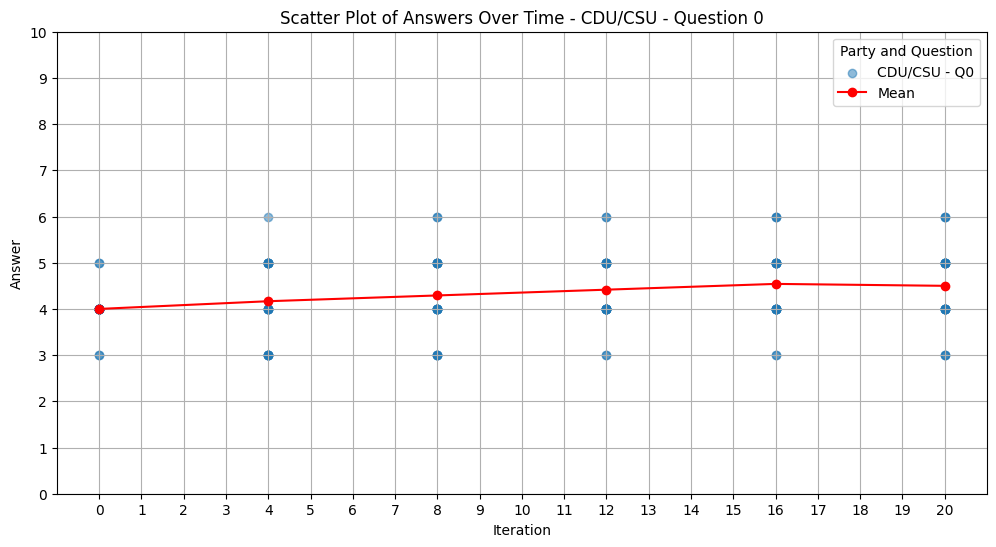

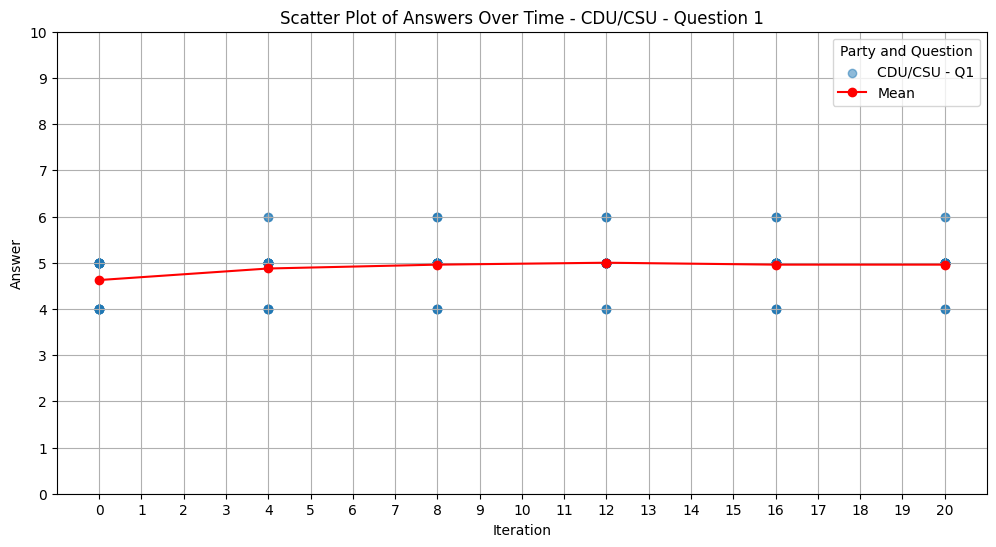

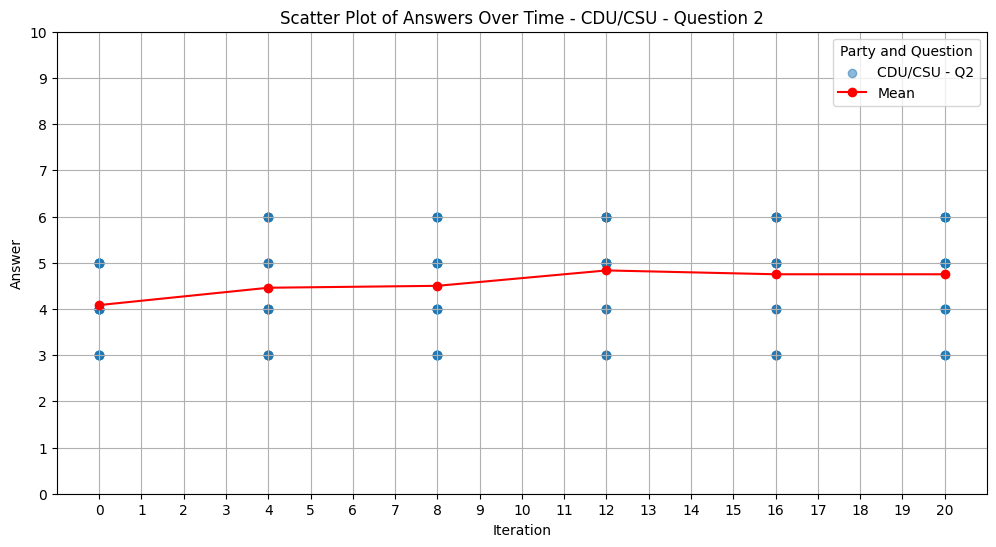

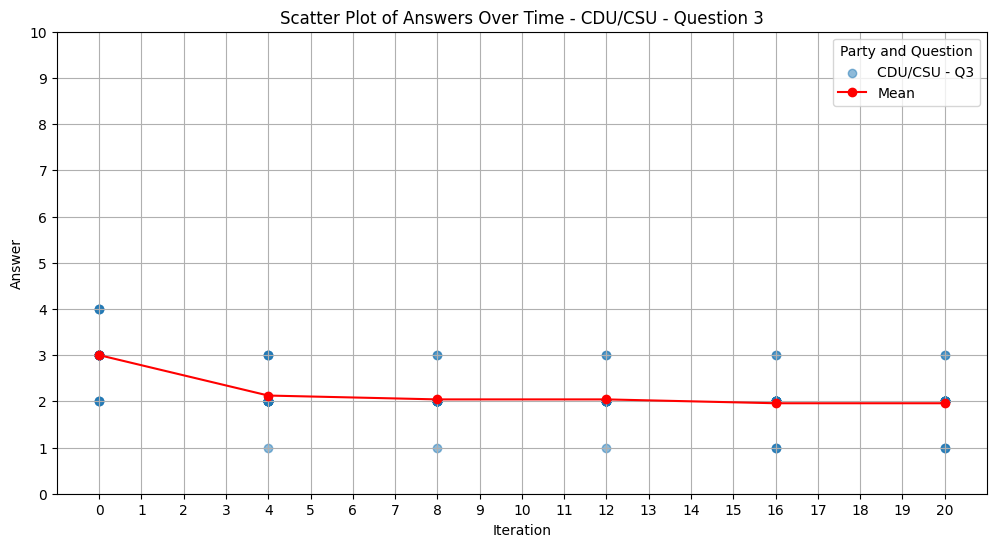

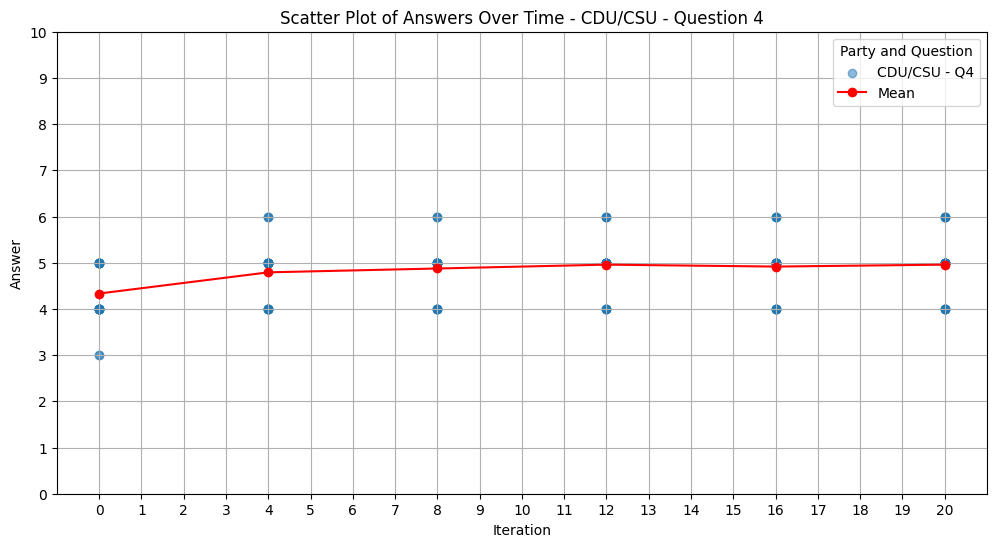

In [6]:
# scatterplot the data, answer over time
import matplotlib.pyplot as plt

plot_df = party_df_non_abs.copy()

plot_df["iteration"] = plot_df["iteration"].str.replace("T", "").astype(int)
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

# Create a scatter plot for each party separately
# for party in plot_df["party"].unique():
party = "CDU/CSU"
for question in plot_df["question_index"].unique():
    party_data = plot_df[(plot_df["party"] == party) & (plot_df["question_index"] == question)]
    plt.figure(figsize=(12, 6))
    plt.scatter(party_data["iteration"], party_data["answer"], label=f"{party} - Q{question}", alpha=0.5)
    # Plot mean line
    means = party_data.groupby("iteration")["answer"].mean()
    plt.plot(means.index, means.values, color="red", marker="o", label="Mean")
    plt.title(f"Scatter Plot of Answers Over Time - {party} - Question {question}")
    plt.xticks(range(0, 21))
    plt.yticks(range(0, 11))
    plt.xlabel("Iteration")
    plt.ylabel("Answer")
    plt.legend(title="Party and Question")
    plt.grid()
    plt.show()

# party_data = plot_df[plot_df["party"] == party]
# plt.figure(figsize=(12, 6))
# plt.scatter(party_data["iteration"], party_data["answer"], label=party, alpha=0.5)
# plt.title(f"Scatter Plot of Answers Over Time - {party}")
# plt.xticks(range(0, 21))
# plt.yticks(range(0, 11))
# plt.xlabel("Iteration")
# plt.ylabel("Answer")
# plt.legend(title="Party")
# plt.grid()
# plt.show()

In [7]:
party_df_non_abs

,party,debate_with,version,question_index,iteration,answer
0,CDU/CSU,AfD,out_0,0,T0,4
1,AfD,CDU/CSU,out_0,0,T0,3
2,Bündnis 90/Die Grünen,AfD,out_0,0,T0,4
3,AfD,Bündnis 90/Die Grünen,out_0,0,T0,2
4,Die Linke,FDP,out_0,0,T0,6
...,...,...,...,...,...,...
5023,CDU/CSU,SPD,out_2,4,T20,5
5024,SPD,FDP,out_2,4,T20,6
5025,FDP,SPD,out_2,4,T20,7
5026,FDP,CDU/CSU,out_2,4,T20,6


In [16]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party

import statsmodels.api as sm
import statsmodels.formula.api as smf


# remove nan
lmm_data = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)


lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)

lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
lmm_data["time"] = lmm_data["iteration"].str.extract(r"T(\d+)").astype(float)

# reset index
lmm_data = lmm_data.reset_index(drop=True)

groups = (
    lmm_data["party"]
    + "_"
    + lmm_data["debate_with"].astype(str)
    + "_"
    + lmm_data["version"].astype(str)
)

# categorize the question_index
lmm_data["question_index"] = lmm_data["question_index"].astype("category")


md = smf.mixedlm(
    "answer ~ time + party*question_index + time * question_index + time:version:question_index",
    lmm_data,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())


                            Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             answer    
No. Observations:               5028                Method:                         REML      
No. Groups:                     147                 Scale:                          0.6197    
Min. group size:                30                  Log-Likelihood:                 -6133.6773
Max. group size:                60                  Converged:                      Yes       
Mean group size:                34.2                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           3.083    0.091  33.783 0.00

In [18]:
from scipy.stats import chi2



# Model A: Includes 'version' and all its interactions
full_model = smf.mixedlm(
    "answer ~ time * version * question_index + party",
    lmm_data,
    groups=groups,
).fit(reml=False) # <--- IMPORTANT CHANGE HERE
print("Full Model Summary:")
print(full_model.summary())


# Model B: Excludes 'version' and all its interactions
reduced_model = smf.mixedlm(
    "answer ~ time * question_index + party",
    lmm_data,
    groups=groups,
).fit(reml=False) # <--- IMPORTANT CHANGE HERE
print("Reduced Model Summary:")
print(reduced_model.summary())


print("full_model:")
print(full_model.llf)
print(full_model.params.shape[0])


print("reduced_model:")
print(reduced_model.llf)
print(reduced_model.params.shape[0])



lr_stat = 2 * (full_model.llf - reduced_model.llf)
df_diff = full_model.params.shape[0] - reduced_model.params.shape[0]
p_value = chi2.sf(lr_stat, df_diff)

print("\nLikelihood-Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")

Full Model Summary:
                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          answer    
No. Observations:            5028             Method:                      ML        
No. Groups:                  147              Scale:                       1.3082    
Min. group size:             30               Log-Likelihood:              -7855.5493
Max. group size:             60               Converged:                   Yes       
Mean group size:             34.2                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                  4.404    0.126  34.882 0.000  4.156  4.651
version[T.out_1]                           0.138    0.161 

In [19]:
def backward_elimination(data, groups):
    """
    Performs backward elimination for a mixed-effects model.
    """
    # --- Define model formulas ---
    # Start with the most complex model
    current_formula = "answer ~ time * version * question_index + party"
    
    print(f"Starting backward elimination with full model:\n{current_formula}\n")
    
    # --- Test 1: Three-way interaction (time:version:question_index) ---
    print("--- Testing 3-way interaction: time:version:question_index ---")
    
    full_model = smf.mixedlm(current_formula, data, groups=groups).fit(reml=False)
    
    # Model without the 3-way interaction
    reduced_formula_1 = "answer ~ time*version + time*question_index + version*question_index + party"
    reduced_model_1 = smf.mixedlm(reduced_formula_1, data, groups=groups).fit(reml=False)
    
    lr_stat = 2 * (full_model.llf - reduced_model_1.llf)
    df_diff = full_model.params.shape[0] - reduced_model_1.params.shape[0]
    p_value = chi2.sf(lr_stat, df_diff)
    
    print(f"LRT P-value for time:version:question_index = {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: The 3-way interaction is significant. Stopping elimination.")
        print(f"\nFinal recommended model:\n{current_formula}")
        return current_formula
    else:
        print("Result: The 3-way interaction is NOT significant. Removing it.")
        current_formula = reduced_formula_1

    # --- Test 2: Two-way interactions ---
    print("\n--- Testing 2-way interactions ---")
    
    # Terms to test, in order of complexity
    two_way_terms = {
        "time:version": "answer ~ time*question_index + version*question_index + party + time + version",
        "time:question_index": "answer ~ time*version + version*question_index + party + time + question_index",
        "version:question_index": "answer ~ time*version + time*question_index + party + version + question_index"
    }
    
    for term, reduced_formula in two_way_terms.items():
        print(f"Testing term: {term}")
        
        full_model = smf.mixedlm(current_formula, data, groups=groups).fit(reml=False)
        reduced_model = smf.mixedlm(reduced_formula, data, groups=groups).fit(reml=False)
        
        lr_stat = 2 * (full_model.llf - reduced_model.llf)
        df_diff = full_model.params.shape[0] - reduced_model.params.shape[0]
        p_value = chi2.sf(lr_stat, df_diff)
        
        print(f"LRT P-value for {term} = {p_value:.4f}")
        
        if p_value >= 0.05:
            print(f"Result: {term} is NOT significant. Removing it.")
            current_formula = reduced_formula
        else:
            print(f"Result: {term} is significant. Keeping it.")
            
    print(f"\nFinal recommended model after testing interactions:\n{current_formula}")
    
    # You could extend this logic to test main effects if all interactions are removed.
    
    return current_formula

# --- Run the analysis ---
# Ensure lmm_data and groups are defined from the previous cell
final_model_formula = backward_elimination(lmm_data, groups)

print("\n--- Fitting the final recommended model ---")
final_model = smf.mixedlm(final_model_formula, lmm_data, groups=groups).fit()
print(final_model.summary())

Starting backward elimination with full model:
answer ~ time * version * question_index + party

--- Testing 3-way interaction: time:version:question_index ---
LRT P-value for time:version:question_index = 0.9382
Result: The 3-way interaction is NOT significant. Removing it.

--- Testing 2-way interactions ---
Testing term: time:version
LRT P-value for time:version = 0.6355
Result: time:version is NOT significant. Removing it.
Testing term: time:question_index
LRT P-value for time:question_index = 0.0000
Result: time:question_index is significant. Keeping it.
Testing term: version:question_index
LRT P-value for version:question_index = 0.0101
Result: version:question_index is significant. Keeping it.

Final recommended model after testing interactions:
answer ~ time*question_index + version*question_index + party + time + version

--- Fitting the final recommended model ---
                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Va